In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets 
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
batch_size        = 128
device            = torch.device('cuda')
normalize         = lambda x: (x - 0.1307) / 0.3081
reverse_normalize = lambda x: (x * 0.3081) + 0.1307

In [3]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img).data.squeeze().cpu().numpy()
    print(img_data(img).min(), img_data(img).max())
    plt.imshow(img_data(img), cmap = 'gray')    

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train = True,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    ),
    shuffle = True,
    batch_size = batch_size
)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train = False,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    ),
    shuffle = False,
    batch_size = 2 * batch_size
)

In [6]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            *_, y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [7]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y = X.to(device), y.to(device)
            *_, y_pred = model(X)
            class_pred = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1  , 16 , 3, padding = 1)
        self.conv2 = nn.Conv2d(16 , 32, 3, padding = 1)
        self.fc1   = nn.Linear(32 * 7 * 7, 32)
        self.fc2   = nn.Linear(32        , 10)
        
    def forward(self, x):
        batch_size    = x.size(0)
        out_conv1     = F.relu(self.conv1(x))
        out_max_pool1 = F.max_pool2d(out_conv1, kernel_size = (2, 2))
        out_conv2     = F.relu(self.conv2(out_max_pool1))
        out_max_pool2 = F.max_pool2d(out_conv2, kernel_size = (2, 2))
        out_view      = out_max_pool2.view(-1, 32 * 7 * 7)
        out_fc1       = F.relu(self.fc1(out_view))
        out_fc2       = self.fc2(out_fc1)
        
        return (
            out_conv1.view(batch_size, -1),
            out_conv2.view(batch_size, -1),
            out_fc1,
            out_fc2
        )

In [9]:
cnn       = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())

In [10]:
train(cnn, device, train_loader, optimizer, criterion, 5, len(train_loader) // 5)

Train epoch 0: [    0/60000] Loss:  2.3095
Train epoch 0: [11904/60000] Loss:  0.2937
Train epoch 0: [23808/60000] Loss:  0.1460
Train epoch 0: [35712/60000] Loss:  0.0683
Train epoch 0: [47616/60000] Loss:  0.1304
Train epoch 0: [59520/60000] Loss:  0.1669


Train epoch 1: [    0/60000] Loss:  0.1608
Train epoch 1: [11904/60000] Loss:  0.1034
Train epoch 1: [23808/60000] Loss:  0.0554
Train epoch 1: [35712/60000] Loss:  0.0370
Train epoch 1: [47616/60000] Loss:  0.0432
Train epoch 1: [59520/60000] Loss:  0.1160


Train epoch 2: [    0/60000] Loss:  0.0484
Train epoch 2: [11904/60000] Loss:  0.0600
Train epoch 2: [23808/60000] Loss:  0.0358
Train epoch 2: [35712/60000] Loss:  0.0258
Train epoch 2: [47616/60000] Loss:  0.0725
Train epoch 2: [59520/60000] Loss:  0.0349


Train epoch 3: [    0/60000] Loss:  0.0462
Train epoch 3: [11904/60000] Loss:  0.0425
Train epoch 3: [23808/60000] Loss:  0.0064
Train epoch 3: [35712/60000] Loss:  0.0242
Train epoch 3: [47616/60000] Loss:  0.0486
Train epoch 3: [59520/60000] Loss:  0.0382


Train epoch 4: [    0/60000] Loss:  0.0178
Train epoch 4: [11904/60000] Loss:  0.0760
Train epoch 4: [23808/60000] Loss:  0.0192
Train epoch 4: [35712/60000] Loss:  0.0278
Train epoch 4: [47616/60000] Loss:  0.0681
Train epoch 4: [59520/60000] Loss:  0.1092



In [11]:
accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


[Train] Accuracy: 99.22%, loss:  0.0262



[Test] Accuracy: 98.55%, loss:  0.0396


Real label: 7
Predicted label: 186858


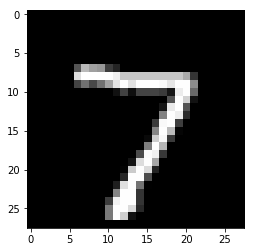

In [12]:
X, y = next(iter(test_loader))
plt.imshow(X[0].squeeze(), cmap = 'gray')
print(f'Real label: {y[0].item()}')
print(f'Predicted label: {cnn(X.to(device))[0].argmax().item()}')

In [13]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    *_, y_pred      = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    adv_example.clamp_(normalize(0), normalize(1))
    
    return adv_example

In [14]:
def adv_sample_process(model, epsilon, ex_idx, X, y):
    source      = X[ex_idx, ...].unsqueeze(0).to(device)
    *_, y_pred  = model(source)
    adv_example = generate_adv_example(model, epsilon, criterion, source)
    *_,adv_pred = model(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {y[ex_idx].item()}')
    print(f'Predicted label: {adv_pred[0].argmax().item()}')

Class 0: -5.3032 	->	 -6.9230
Class 1: 0.0172 	->	 -0.8256
Class 2: -1.5987 	->	 -0.7613
Class 3: 0.6923 	->	 4.2454
Class 4: -11.0905 	->	 -10.5981
Class 5: -6.5219 	->	 -0.3454
Class 6: -19.6092 	->	 -14.7004
Class 7: 12.3082 	->	 4.1481
Class 8: -7.0683 	->	 -2.4003
Class 9: -1.3468 	->	 -1.6472
0.0 1.0
1.4901161e-08 0.99999994
Real label: 7
Predicted label: 3


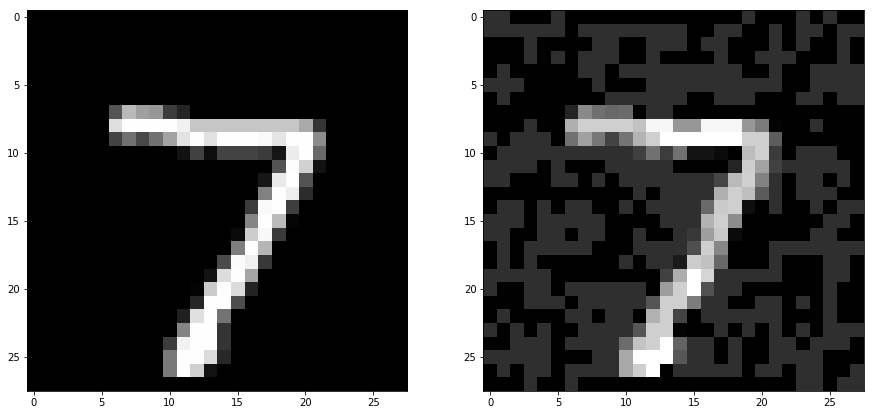

In [15]:
adv_sample_process(cnn, 0.6, 0, X, y)